In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import category_encoders as ce # импорт для работы с кодировщиком
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import plotly.express as px

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
# !pip freeze > kaggle_requirements.txt
!pip freeze > local_venv_requirements.txt

In [4]:
# Подгрузим наши данные из соревнования

# DATA_DIR = '/kaggle/input/sf-booking/'
# df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_train = pd.read_csv('hotels_train.csv.zip')
# df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
df_test = pd.read_csv('hotels_test.csv.zip')
# sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн
sample_submission = pd.read_csv('submission.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [8]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [9]:
sample_submission.head(2)

,reviewer_score,id
0,8.685,488440
1,7.578,274649


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewer_score  128935 non-null  float64
 1   id              128935 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 2.0 MB


In [11]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

C:\Users\User\AppData\Local\Temp\ipykernel_4968\1819849330.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

# ОБРАБОТКА ДАТАСЕТА

In [13]:
# data['lat'] = data['lat'].fillna(0) # Заполняем пропуски нулями
# data['lng'] = data['lng'].fillna(0)

In [14]:
data = data.drop('lat', axis=1) # Удаляем координаты
data = data.drop('lng', axis=1)

### Поищем дубликаты в датасете

In [15]:
data.duplicated().value_counts()

False    515402
True        336
dtype: int64

Дубликатов в датасете 336, но мы не можем их удалить т.к. тест не будет совпадать с сабмитом.

### Посмотрим на корреляцию.

C:\Users\User\AppData\Local\Temp\ipykernel_4968\3745576415.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr());


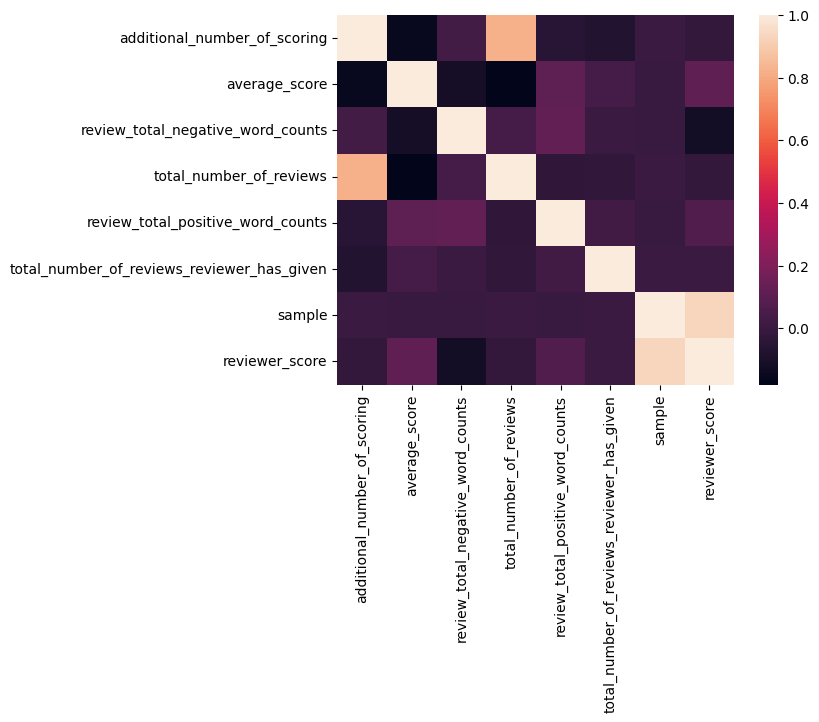

In [16]:
sns.heatmap(data.corr());

Наблюдается сильная корреляция между признаками total_number_of_reviews и additional_number_of_scoring. Нужно удалить один из них.

### Удалим признак additional_number_of_scoring.

In [17]:
data = data.drop('additional_number_of_scoring', axis=1)
data.head(4)

,hotel_address,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,0,0.0
3,Piazza Della Repubblica 17 Central Station 201...,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,0,0.0


### удалим признак days_since_review
Поскольку мы не привязаны к какому либо времянному ряду, будет логичным не оценивать этот признак.

In [18]:
data = data.drop('days_since_review', axis=1)

### Обработка даты
От даты написания отзыва оставим только месяц. Поскольку мы не привязаны к какому либо временному промежутку, но может прослеживаться различный характер отзывов в зависимости от времени года.

In [19]:
data['review_date'] = pd.to_datetime(data['review_date'])  # Преобразуем признак в формат даты.
data['review_date_month'] = pd.DatetimeIndex(data['review_date']).month # Оставим только месяц.
data = data.drop('review_date', axis=1) # Удалим исходный столбец.
data.shape

(515738, 14)

In [20]:
#обработаем месяцы OneHotEncoderom, создав 12 новых признаков в бинарном формате.
encoder = ce.OneHotEncoder(cols=['review_date_month']) # указываем столбец для кодирования.
type_bin = encoder.fit_transform(data['review_date_month'])
data = pd.concat([data, type_bin], axis=1).reset_index()
data = data.drop('review_date_month', axis=1)
data.shape

(515738, 26)

### Стандартизируем числовые признаки

In [21]:
col_name= data[['average_score',
                'review_total_negative_word_counts',
                'review_total_positive_word_counts',
                'total_number_of_reviews_reviewer_has_given',
                'total_number_of_reviews'
               ]]

scaler = preprocessing.StandardScaler()
data_scalar = scaler.fit_transform(col_name)
data_scalar = pd.DataFrame(data_scalar, columns=col_name.columns)

data_scalar.sample(3)

,average_score,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,total_number_of_reviews
396840,0.551983,-0.321293,-0.494239,-0.015036,-0.166019
283023,-0.360346,-0.253932,-0.631827,0.981321,-0.989334
233224,0.551983,1.160647,-0.356650,-0.286770,2.048471


In [22]:
#заменяем признаки на скалированные в исходном датасете.
data = data.drop(col_name, axis=1) # Удаляем исходные числовые признаки.
data_numeric = pd.concat([data, data_scalar], axis =1).reset_index() # Присоединяем скалированные признаки.
data_numeric = data_numeric.drop('index', axis=1) # Удаляем столбец индекс.
data_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 26 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   level_0                                     515738 non-null  int64  
 1   hotel_address                               515738 non-null  object 
 2   hotel_name                                  515738 non-null  object 
 3   reviewer_nationality                        515738 non-null  object 
 4   negative_review                             515738 non-null  object 
 5   positive_review                             515738 non-null  object 
 6   tags                                        515738 non-null  object 
 7   sample                                      515738 non-null  int64  
 8   reviewer_score                              515738 non-null  float64
 9   review_date_month_1                         515738 non-null  int64  
 

## Обработка текстовых признаков:

### Разберемся с адресом отеля

In [23]:
# взглянем на содержимое.
data_numeric['hotel_address']

0                        Via Senigallia 6 20161 Milan Italy
1         Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...
2               Mallorca 251 Eixample 08008 Barcelona Spain
3         Piazza Della Repubblica 17 Central Station 201...
4         Singel 303 309 Amsterdam City Center 1012 WJ A...
                                ...                        
515733    9 Knaresborough Place Kensington and Chelsea L...
515734    Landstra er Hauptstra e 155 03 Landstra e 1030...
515735    29 31 Gower Street Camden London WC1E 6HG Unit...
515736    31 Great Cumberland Place Westminster Borough ...
515737    25 Courtfield Gardens Kensington and Chelsea L...
Name: hotel_address, Length: 515738, dtype: object

In [24]:
# оставим только страну (т.к. весь датасет собран всего из 6-ти городов, 1 город в 1 стране).
data_numeric['hotel_country'] = data_numeric['hotel_address'].apply(lambda x: x.split(' ')[-1:]) 
data_numeric['hotel_country'] = data_numeric['hotel_country'].astype('str')

In [25]:
data_numeric['hotel_country'].value_counts()

['Kingdom']        262301
['Spain']           60149
['France']          59928
['Netherlands']     57214
['Austria']         38939
['Italy']           37207
Name: hotel_country, dtype: int64

In [26]:
# 6 стран обработаем OneHotEncoder, создавая 6 новых бинарных признаков.
encoder = ce.OneHotEncoder(cols=['hotel_country']) # Указываем столбец для кодирования.
type_bin = encoder.fit_transform(data_numeric['hotel_country']) # Создаем датасет с новыми признаками
type_bin

,hotel_country_1,hotel_country_2,hotel_country_3,hotel_country_4,hotel_country_5,hotel_country_6
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,0,1,0,0,0
3,1,0,0,0,0,0
4,0,1,0,0,0,0
...,...,...,...,...,...,...
515733,0,0,0,1,0,0
515734,0,0,0,0,0,1
515735,0,0,0,1,0,0
515736,0,0,0,1,0,0


In [27]:
data_num= pd.concat([data_numeric, type_bin], axis=1) # Соединяем датасеты.
data_num = data_num.drop(['hotel_country', 'hotel_address'], axis=1) # Удаляем исходные признаки.
data_num.shape

(515738, 31)

In [28]:
data_num.sample(2)

,level_0,hotel_name,reviewer_nationality,negative_review,positive_review,tags,sample,reviewer_score,review_date_month_1,review_date_month_2,...,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,total_number_of_reviews,hotel_country_1,hotel_country_2,hotel_country_3,hotel_country_4,hotel_country_5,hotel_country_6
266234,266234,Hyatt Regency London The Churchill,Greece,service,The bed and the bathroom,"[' Leisure trip ', ' Family with young childre...",1,6.7,0,0,...,-0.557056,-0.494239,-0.377348,-0.802923,0,0,0,1,0,0
318466,318466,Millennium Gloucester Hotel London,United Kingdom,Duvet could have fitted the bed,The club lounge Breakfast was good and varied...,"[' Leisure trip ', ' Couple ', ' Club Double R...",1,8.3,0,0,...,-0.354974,-0.035611,-0.558504,1.286863,0,0,0,1,0,0


### Разберемся с названием отеля

In [29]:
# в датасете более 1000 уникальных названий отелей, обработаем их LabelEncoder,
# а затем проскалируем значения,чтоб не преувеличивать вес высоких лейблов
data_num['hotel_name'] = LabelEncoder().fit_transform(data_num['hotel_name'])
temp_array = np.array(data_num['hotel_name']).reshape(data_num.shape[0],1)
data_num_scalar = scaler.fit_transform(temp_array)
data_num_text = pd.DataFrame(data_num_scalar, columns=['hotel_scalar_name'])
data_num_text

,hotel_scalar_name
0,-0.340735
1,1.502440
2,-1.621885
3,-0.068573
4,-0.294268
...,...
515733,-0.121678
515734,-1.464784
515735,-1.303257
515736,1.323212


In [30]:
# заменим hotel_name на скалированное значение
data_num = data_num.drop('hotel_name', axis=1) # Удаляем исходный признак
data_before_result = pd.concat([data_num, data_num_text], axis=1) # Присоединяем скалированный
data_before_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 31 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   level_0                                     515738 non-null  int64  
 1   reviewer_nationality                        515738 non-null  object 
 2   negative_review                             515738 non-null  object 
 3   positive_review                             515738 non-null  object 
 4   tags                                        515738 non-null  object 
 5   sample                                      515738 non-null  int64  
 6   reviewer_score                              515738 non-null  float64
 7   review_date_month_1                         515738 non-null  int64  
 8   review_date_month_2                         515738 non-null  int64  
 9   review_date_month_3                         515738 non-null  int64  
 

In [31]:
data_before_result.sample(2)

,level_0,reviewer_nationality,negative_review,positive_review,tags,sample,reviewer_score,review_date_month_1,review_date_month_2,review_date_month_3,...,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,total_number_of_reviews,hotel_country_1,hotel_country_2,hotel_country_3,hotel_country_4,hotel_country_5,hotel_country_6,hotel_scalar_name
496338,496338,Switzerland,only one bathrobe in room stained small towel...,pool and spa great bed and breakfast,"[' Leisure trip ', ' Group ', ' Superior Doubl...",1,8.3,0,0,0,...,-0.448376,-0.196192,-0.442615,1,0,0,0,0,0,1.084241
201124,201124,United States of America,TGhe showere was missing some caulking around...,Great location for getting around Milan Nice ...,"[' Leisure trip ', ' Couple ', ' Double or Twi...",1,9.6,0,0,0,...,-0.219062,-0.558504,-0.933669,1,0,0,0,0,0,-1.668352


### Обработка тегов

In [32]:
#Из всего набора тегов оставим 10 наиболее популярных в виде бинарных признаков
c = Counter()
for tags in data['tags'].apply(lambda s: [x.strip() for x in s[1:-1].replace("'",'').split(',')]):
    for tag in tags:
        c[tag] += 1

#display (c) # Получили объект типа counter со словарем внутри, где значениями являются количества тегов.

In [33]:
# Отсортируем полученный словарь по значениям, чтобы убедиться в правильности кода.
c_sorted_values = sorted(c.values())
sorted_dict = {}

for i in c_sorted_values:
    for k in c.keys():
        if c[k] == i:
            sorted_dict[k] = c[k]
            break
            
#display(sorted_dict)

In [34]:
final_dict = {k:v for k, v in c.items() if v >= 61015} # Возмем 10 тегов максимальной популярности.
final_dict

{'Leisure trip': 417778,
 'Couple': 252294,
 'Stayed 2 nights': 133937,
 'Group': 65392,
 'Stayed 1 night': 193645,
 'Business trip': 82939,
 'Solo traveler': 108545,
 'Submitted from a mobile device': 307640,
 'Stayed 3 nights': 95821,
 'Family with young children': 61015}

In [35]:
for key in final_dict:
    key_name = key.lower().replace(' ','_')
    data_before_result[f"tag_{key_name}"] = data_before_result['tags'].apply(lambda keys: int(key in keys))

In [36]:
data_before_result.drop(['level_0', 'tags'], axis = 1, inplace=True)

In [37]:
data_before_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 39 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   reviewer_nationality                        515738 non-null  object 
 1   negative_review                             515738 non-null  object 
 2   positive_review                             515738 non-null  object 
 3   sample                                      515738 non-null  int64  
 4   reviewer_score                              515738 non-null  float64
 5   review_date_month_1                         515738 non-null  int64  
 6   review_date_month_2                         515738 non-null  int64  
 7   review_date_month_3                         515738 non-null  int64  
 8   review_date_month_4                         515738 non-null  int64  
 9   review_date_month_5                         515738 non-null  int64  
 

### Национальности

In [38]:
# Возьмем 10 самых частых национальностей, остальные пометим как other, обработаем labelEncoder
data_before_result['reviewer_nationality'].nunique()

227

In [39]:
pop_suburb= data_before_result['reviewer_nationality'].value_counts().nlargest(10).index
pop_suburb

Index([' United Kingdom ', ' United States of America ', ' Australia ',
       ' Ireland ', ' United Arab Emirates ', ' Saudi Arabia ',
       ' Netherlands ', ' Switzerland ', ' Germany ', ' Canada '],
      dtype='object')

In [40]:
data_before_result['reviewer_nationality'] = data_before_result['reviewer_nationality'].apply(lambda x: x if x in pop_suburb else 'Other')
data_before_result['reviewer_nationality'].unique()

array([' United Kingdom ', 'Other', ' United States of America ',
       ' Netherlands ', ' Ireland ', ' Canada ', ' Australia ',
       ' Saudi Arabia ', ' Germany ', ' United Arab Emirates ',
       ' Switzerland '], dtype=object)

In [41]:
data_before_result['reviewer_nationality'] = LabelEncoder().fit_transform(data_before_result['reviewer_nationality'])
data_before_result.head(1)

,reviewer_nationality,negative_review,positive_review,sample,reviewer_score,review_date_month_1,review_date_month_2,review_date_month_3,review_date_month_4,review_date_month_5,...,tag_leisure_trip,tag_couple,tag_stayed_2_nights,tag_group,tag_stayed_1_night,tag_business_trip,tag_solo_traveler,tag_submitted_from_a_mobile_device,tag_stayed_3_nights,tag_family_with_young_children
0,8,Would have appreciated a shop in the hotel th...,Hotel was great clean friendly staff free bre...,0,0.0,1,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0


### Обработка отзывов

In [42]:
replace = {    
    'positive_review': ['no positive', 'nothing'],
    'negative_review': [
        'nothing really', 'no negative', 'nothing', 'n a', 'none', 'nothing at all', 'nothing to dislike',
        'everything was perfect', 'na', 'can t think of anything', 'nil','everything was great', 'absolutely nothing',
        'nothing to complain about', 'no', 'nothing not to like', 'nothing all good', 'no complaints', 'i liked everything', 
        'liked everything'
    ]
}

In [43]:
for key in replace:
    for value in replace[key]:
        data_before_result.loc[data_num[key].str.strip().str.lower()==value, key] = ''

In [44]:
data_before_result['review_total_positive_word_counts'] = data_before_result['positive_review'].apply(lambda s: len(s.strip().split(' ')))
data_before_result['review_total_negative_word_counts'] = data_before_result['negative_review'].apply(lambda s: len(s.strip().split(' ')))
data_before_result['review_total_negative_word_counts']

0         50
1          9
2          1
3          1
4          1
          ..
515733     1
515734     1
515735    10
515736     1
515737    18
Name: review_total_negative_word_counts, Length: 515738, dtype: int64

In [45]:
data_before_result['review_diff'] = data_before_result['positive_review'].str.len() - data_before_result['negative_review'].str.len()
data_before_result['review_diff']

0          75
1         -44
2          18
3         155
4          32
         ... 
515733     35
515734    436
515735     -5
515736     28
515737      9
Name: review_diff, Length: 515738, dtype: int64

In [46]:
polarity_columns = ['neg', 'neu', 'pos', 'compound']

In [47]:
analyzer = SentimentIntensityAnalyzer()

In [48]:
def get_polarity(row, analyzer):
    positive_counter = Counter(analyzer.polarity_scores(row['positive_review']))
    negative_counter = Counter(analyzer.polarity_scores(row['negative_review']))
    result_counter = positive_counter + negative_counter
    return [result_counter[col] for col in polarity_columns]

polarities = list(data_before_result.apply(get_polarity, analyzer=analyzer, axis=1))

data_polarity = pd.DataFrame(polarities, columns=['neg', 'neu', 'pos', 'compound'])

In [49]:
data_result = pd.concat([data_before_result, data_polarity], axis=1)
data_result.drop(['positive_review', 'negative_review'], axis=1, inplace=True)
data_result.sample(2)

,reviewer_nationality,sample,reviewer_score,review_date_month_1,review_date_month_2,review_date_month_3,review_date_month_4,review_date_month_5,review_date_month_6,review_date_month_7,...,tag_business_trip,tag_solo_traveler,tag_submitted_from_a_mobile_device,tag_stayed_3_nights,tag_family_with_young_children,review_diff,neg,neu,pos,compound
450270,7,1,3.3,0,0,0,0,0,0,0,...,0,0,1,1,0,56,0.000,0.327,0.673,0.8519
44778,8,0,0.0,0,0,0,0,1,0,0,...,1,1,1,0,0,-193,0.136,1.864,0.000,0.0000


In [50]:
data_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   reviewer_nationality                        515738 non-null  int32  
 1   sample                                      515738 non-null  int64  
 2   reviewer_score                              515738 non-null  float64
 3   review_date_month_1                         515738 non-null  int64  
 4   review_date_month_2                         515738 non-null  int64  
 5   review_date_month_3                         515738 non-null  int64  
 6   review_date_month_4                         515738 non-null  int64  
 7   review_date_month_5                         515738 non-null  int64  
 8   review_date_month_6                         515738 non-null  int64  
 9   review_date_month_7                         515738 non-null  int64  
 

# Создание и обучение модели

In [51]:
from sklearn.feature_selection import chi2, f_classif

## Проверка на мультиколлинеарность

In [52]:
# корреляция признаков (оставляем только сильную связь для наглядности)
pivot = data_result.corr()
pivot = pivot.drop(['sample', 'reviewer_score'], axis=0)
pivot = pivot.drop(['sample', 'reviewer_score'], axis=1)
pivot
for col in pivot:
    pivot[col] = pivot[col].apply(lambda x: np.nan if (abs(x) < 0.85 or x == 1) else x)
# for col in pivot:
#     pivot = pivot.dropna(how='all')
#     pivot = pivot.dropna(how='all', axis='columns')

fig = px.imshow(pivot)
fig.show()

Обнаруживаем мультиколлинеарность между признаками tag_leisure_trip и tag_business_trip. Удаляем tag_business_trip.

In [53]:
data_result.drop(['tag_business_trip'], axis=1, inplace=True)

In [54]:
data_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 41 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   reviewer_nationality                        515738 non-null  int32  
 1   sample                                      515738 non-null  int64  
 2   reviewer_score                              515738 non-null  float64
 3   review_date_month_1                         515738 non-null  int64  
 4   review_date_month_2                         515738 non-null  int64  
 5   review_date_month_3                         515738 non-null  int64  
 6   review_date_month_4                         515738 non-null  int64  
 7   review_date_month_5                         515738 non-null  int64  
 8   review_date_month_6                         515738 non-null  int64  
 9   review_date_month_7                         515738 non-null  int64  
 

# ОБУЧЕНИЕ МОДЕЛИ

In [55]:
# Теперь выделим тестовую часть
train_data = data_result.query('sample==1').drop(['sample'], axis=1)
test_data = data_result.query('sample==0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [56]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [57]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 40), (386803, 40), (386803, 39), (309442, 39), (77361, 39))

In [58]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [59]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [60]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 14.9min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   15.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   19.7s finished


In [61]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.8724677593791874


In [62]:
# оцениваем точность прогноза
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) # Этот коэффициент соответствует верхнему, если его вычесть из единицы.

print('MAPE:', mean_absolute_percentage_error(y_test, y_pred)) 

MAPE: 0.12459339235182346


In [63]:
metrics.mean_absolute_error(y_test, y_pred) + mean_absolute_percentage_error(y_test, y_pred)

0.9970611517310108

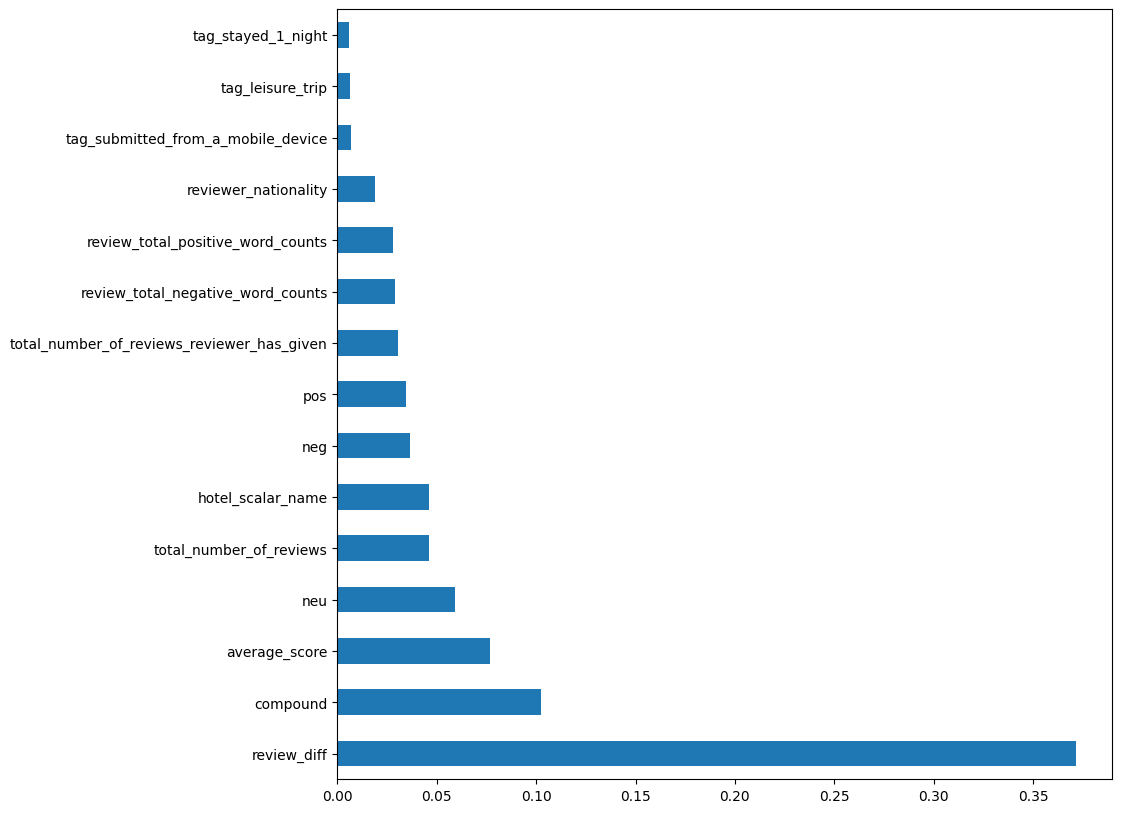

In [64]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh');

In [65]:
test_data.sample(10)

,reviewer_nationality,reviewer_score,review_date_month_1,review_date_month_2,review_date_month_3,review_date_month_4,review_date_month_5,review_date_month_6,review_date_month_7,review_date_month_8,...,tag_stayed_1_night,tag_solo_traveler,tag_submitted_from_a_mobile_device,tag_stayed_3_nights,tag_family_with_young_children,review_diff,neg,neu,pos,compound
42594,8,0.0,0,0,0,0,1,0,0,0,...,1,0,1,0,0,34,0.097,1.594,0.310,0.6425
11486,9,0.0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,-10,0.267,1.156,0.577,0.5749
46017,5,0.0,0,0,0,0,0,1,0,0,...,0,0,1,1,0,178,0.000,0.893,0.107,0.5222
65534,0,0.0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,-6,0.000,2.000,0.000,0.0000
96467,8,0.0,0,0,0,0,1,0,0,0,...,0,0,1,1,0,-152,0.035,1.474,0.491,0.6984
27013,8,0.0,0,0,0,1,0,0,0,0,...,1,0,1,0,0,-172,0.097,0.903,0.000,0.0000
23098,8,0.0,0,0,0,0,0,0,0,0,...,1,0,1,0,1,-40,0.000,0.737,0.263,0.3612
90802,10,0.0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,-28,0.362,0.638,0.000,0.0000
128213,10,0.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,288,0.000,1.909,0.091,0.6901
69212,10,0.0,0,0,0,0,0,0,1,0,...,1,0,1,0,0,11,0.000,1.000,0.000,0.0000


In [66]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [67]:
sample_submission

,reviewer_score,id
0,8.685,488440
1,7.578,274649
2,7.929,374688
3,9.592,404352
4,9.565,451596
...,...,...
128930,9.219,495812
128931,9.468,315577
128932,8.318,511968
128933,9.614,303386


In [68]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   14.0s finished


In [69]:
predict_submission

array([8.685, 7.578, 7.929, ..., 8.318, 9.614, 7.429])

In [70]:
list(sample_submission)

['reviewer_score', 'id']

In [71]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.685,488440
1,7.578,274649
2,7.929,374688
3,9.592,404352
4,9.565,451596
5,9.241,302161
6,8.056,317079
7,7.847,13963
8,8.694,159785
9,8.016,195089
